In [ ]:
# #!apt install openjdk-8-jdk-headless -qq
# import os
# os.environ["JAVA_HOME"] = "/opt/homebrew/opt/openjdk@11/libexec/openjdk.jdk/Contents/Home"


In [ ]:
import findspark
import json
import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pyspark
import seaborn as sns
import time
from collections import defaultdict
from datetime import datetime
from netrd.distance import NetSimile
from netrd.distance.base import BaseDistance
from netrd.utilities import undirected, unweighted
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, Window
from pyspark.sql import functions as F
from pyspark.sql.functions import ceil, col, row_number, udf
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from scipy.spatial.distance import canberra, pdist, squareform
from scipy.stats import gaussian_kde, kurtosis, skew


In [2]:
spark = SparkSession.builder.appName("CommunityRDD").getOrCreate()
sc = spark.sparkContext

your 131072x1 screen size is bogus. expect trouble
24/11/09 18:48:14 WARN Utils: Your hostname, MadioLaptop resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/11/09 18:48:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/09 18:48:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [21]:
json_file_path = '../Community Detection/10K.json'
with open(json_file_path, 'r') as f:
    community_data = json.load(f)

In [22]:
#community_data_with_ids = add_community_id(community_data)
community_rdd = sc.parallelize(community_data)
type(community_rdd)
print(community_rdd.take(5))

[{'community_id': 1, 'nodes': [371, 340, 378, 667, 974, 368, 627, 64, 168, 257, 925, 767, 549, 890, 899, 226, 45, 71, 72, 381, 707, 973, 812, 839, 96, 433, 670, 468, 466, 876, 402, 646, 593, 366, 612], 'edges': [{'node1': 371, 'node2': 549, 'begintijd': 20240318013535, 'eindtijd': 20240318030219}, {'node1': 371, 'node2': 812, 'begintijd': 20240412020025, 'eindtijd': 20240412053609}, {'node1': 371, 'node2': 670, 'begintijd': 20240606074446, 'eindtijd': 20240606110610}, {'node1': 340, 'node2': 378, 'begintijd': 20240918161950, 'eindtijd': 20240918172041}, {'node1': 378, 'node2': 466, 'begintijd': 20240918071254, 'eindtijd': 20240918140257}, {'node1': 667, 'node2': 767, 'begintijd': 20241101133614, 'eindtijd': 20241101175233}, {'node1': 368, 'node2': 627, 'begintijd': 20240112043512, 'eindtijd': 20240112122716}, {'node1': 368, 'node2': 767, 'begintijd': 20240205225900, 'eindtijd': 20240206062846}, {'node1': 64, 'node2': 627, 'begintijd': 20240407064043, 'eindtijd': 20240407074414}, {'node

In [23]:
#Create a key-value RDD where key = community_id, value = nodes and edges
community_kv_rdd = community_rdd.map(lambda community: (community['community_id'], {
    'nodes': community['nodes'], 
    'edges': community['edges']
}))

type(community_kv_rdd)

pyspark.rdd.PipelinedRDD

In [24]:
#!pip install netrd


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [28]:
#!pip install findspark


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
findspark.init()

In [ ]:
###TemporalNetSimile defintion
"""
Temporalnetsimile.py
--------------

Graph distance based on:
Berlingerio, M., Koutra, D., Eliassi-Rad, T. & Faloutsos, C. NetSimile: A Scalable Approach to Size-Independent Network Similarity. arXiv (2012)

Extended upon netsimile.py, acreditted to:

author: Alex Gates
email: ajgates42@gmail.com (optional)
Submitted as part of the 2019 NetSI Collabathon.
https://netrd.readthedocs.io/en/latest/_modules/netrd/distance/netsimile.html

We wish to note that extensions upon the initial netsimile code is preceded by a ###comment

"""



class TemporalNetSimile(BaseDistance):
    """Compares node signature distributions."""


    @undirected
    @unweighted
    def dist(self, G1, G2):
        """A scalable approach to network similarity.

        A network similarity measure based on node signature distributions.
        
        The results dictionary includes the underlying feature matrices in
        `'feature_matrices'` and the underlying signature vectors in
        `'signature_vectors'`.

        Parameters
        ----------

        G1, G2 (nx.Graph)
            two undirected networkx graphs to be compared.

        Returns
        -------

        dist (float)
            the distance between `G1` and `G2`.

        References
        ----------

        .. [1] Michele Berlingerio, Danai Koutra, Tina Eliassi-Rad,
               Christos Faloutsos: NetSimile: A Scalable Approach to
               Size-Independent Network Similarity. CoRR abs/1209.2684
               (2012)

        """

        # find the graph node feature matrices
        G1_node_features = feature_extraction(G1)
        G2_node_features = feature_extraction(G2)

        # get the graph signature vectors
        G1_signature = graph_signature(G1_node_features)
        G2_signature = graph_signature(G2_node_features)

        # the final distance is the absolute canberra distance
        dist = abs(canberra(G1_signature, G2_signature))

        ###Remove for quicker comp.
        ###self.results['feature_matrices'] = G1_node_features, G2_node_features
        ###self.results['signature_vectors'] = G1_signature, G2_signature
        
        self.results['dist'] = dist

        return dist



def feature_extraction(G):
    """Node feature extraction.

    Parameters
    ----------

    G (nx.Graph): a networkx graph.

    Returns
    -------

    node_features (float): the Nx7 matrix of node features."""

    # necessary data structures
    ###FEATURE NUMBER
    node_features = np.zeros(shape=(G.number_of_nodes(), 10)) 
    node_list = sorted(G.nodes())
    node_degree_dict = dict(G.degree())
    node_clustering_dict = dict(nx.clustering(G))
    egonets = {n: nx.ego_graph(G, n) for n in node_list}

    # node degrees
    degs = [node_degree_dict[n] for n in node_list]

    # clustering coefficient
    clusts = [node_clustering_dict[n] for n in node_list]

    # average degree of neighborhood
    neighbor_degs = [
        np.mean([node_degree_dict[m] for m in egonets[n].nodes if m != n])
        if node_degree_dict[n] > 0
        else 0
        for n in node_list
    ]

    # average clustering coefficient of neighborhood
    neighbor_clusts = [
        np.mean([node_clustering_dict[m] for m in egonets[n].nodes if m != n])
        if node_degree_dict[n] > 0
        else 0
        for n in node_list
    ]

    # number of edges in the neighborhood
    neighbor_edges = [
        egonets[n].number_of_edges() if node_degree_dict[n] > 0 else 0
        for n in node_list
    ]

    # number of outgoing edges from the neighborhood
    # the sum of neighborhood degrees = 2*(internal edges) + external edges
    # node_features[:,5] = node_features[:,0] * node_features[:,2] - 2*node_features[:,4]
    neighbor_outgoing_edges = [
        len(
            [
                edge
                for edge in set.union(*[set(G.edges(j)) for j in egonets[i].nodes])
                if not egonets[i].has_edge(*edge)
            ]
        )
        for i in node_list
    ]

    # number of neighbors of neighbors (not in neighborhood)
    neighbors_of_neighbors = [
        len(
            set([p for m in G.neighbors(n) for p in G.neighbors(m)])
            - set(G.neighbors(n))
            - set([n])
        )
        if node_degree_dict[n] > 0
        else 0
        for n in node_list
    ]

    ###Temporal features on the edges

    ###start time, average start time of the edges of a single node
    ###Loop over all nodes, look at the starttime data from the edges, convert the time to time format, calculate mean start time for each node
    startTime = []
    for n in node_list:
        start_times = []
        for u, v, data in G.edges(n, data=True):
            # Convert begintijd to a datetime object
            start_time_str = str(data['begintijd'])
            start_time = datetime.strptime(start_time_str, '%Y%m%d%H%M%S')
            start_times.append(start_time.timestamp())  # Store as timestamp (seconds since epoch)

        startTime.append(np.mean(start_times) if start_times else 0)

    ###end time, average end time of the edges of a single node
    ###Loop over all nodes, look at the endtime data from the edges, convert the time to time format, calculate mean end time for each node
    endTime = []
    for n in node_list:
        end_times = []
        for u, v, data in G.edges(n, data=True):
            # Convert begintijd to a datetime object
            end_time_str = str(data['eindtijd'])
            end_time = datetime.strptime(end_time_str, '%Y%m%d%H%M%S')
            end_times.append(end_time.timestamp())  # Store as timestamp (seconds since epoch)

        endTime.append(np.mean(end_times) if end_times else 0)
    
    ###duration, average duration of the edges of a single node
    duration = []
    for n in node_list:
        duration.append(endTime[node_list.index(n)] - startTime[node_list.index(n)])
    ### end change

    # assembling the features
    node_features[:, 0] = degs
    node_features[:, 1] = clusts
    node_features[:, 2] = neighbor_degs
    node_features[:, 3] = neighbor_clusts
    node_features[:, 4] = neighbor_edges
    node_features[:, 5] = neighbor_outgoing_edges
    node_features[:, 6] = neighbors_of_neighbors

    ###Time features
    node_features[:, 7] = startTime
    node_features[:, 8] = endTime
    node_features[:, 9] = duration

    return np.nan_to_num(node_features)


def graph_signature(node_features):
    ###FEATURE NUMBER
    signature_vec = np.zeros(10 * 5)

    # for each of the features
    ### FEATURE NUMBER
    for k in range(10):
        # find the mean
        signature_vec[k * 5] = node_features[:, k].mean()
        # find the median
        signature_vec[k * 5 + 1] = np.median(node_features[:, k])
        # find the std
        signature_vec[k * 5 + 2] = node_features[:, k].std()
        # find the skew
        signature_vec[k * 5 + 3] = skew(node_features[:, k])
        # find the kurtosis
        signature_vec[k * 5 + 4] = kurtosis(node_features[:, k])

    return signature_vec


"""
# sample usage
>>>G1 = nx.karate_club_graph()
>>>G2 = nx.krackhardt_kite_graph()

>>>test = TemporalNetSimile()
>>>print(test.dist(G1, G2))
11.45
"""

'\n# sample usage\n>>>G1 = nx.karate_club_graph()\n>>>G2 = nx.krackhardt_kite_graph()\n\n>>>test = TemporalNetSimile()\n>>>print(test.dist(G1, G2))\n11.45\n'

In [7]:

#Based on outcome of above, this is rough sketch of how I would envision it
# Get data from two communities
def Compare(Community1, Community2):
    #Convert into networkX graph to use as input for TemportalNetSimile
    #Load Graphs
    Graph1 = nx.Graph()
    Graph1.add_nodes_from(Community1["nodes"])

    # Add edges with timestamps as edge attributes
    for edge in Community1["edges"]:
        Graph1.add_edge(edge["node1"], edge["node2"], begintijd=edge["begintijd"], eindtijd=edge["eindtijd"])

    Graph2=nx.Graph()
    Graph2.add_nodes_from(Community2["nodes"])
    for edge in Community2["edges"]:
        Graph2.add_edge(edge["node1"], edge["node2"], begintijd=edge["begintijd"], eindtijd=edge["eindtijd"])

    testTime=TemporalNetSimile()
    Similarity = testTime.dist(Graph1, Graph2)
    return(Similarity)

#print(Compare(Community1,Community2))

## comparison pairing evaluation


In [9]:
# load community datasets as rdd
json_file_path = '../Community Detection/20Knode_20edge.json'
with open(json_file_path, 'r') as f:
    average_community_data = json.load(f)

#community_data_with_ids = add_community_id(community_data)
average_community_data_rdd = sc.parallelize(average_community_data)
print(f"number of communities: {average_community_data_rdd.count()}")

number of communities: 9


### cartesian pairing

In [10]:
print(f"number of communities: {average_community_data_rdd.count()}")

# cartesian pairs
t0 = time.time()
cartesian_pairs_rdd = average_community_data_rdd.cartesian(average_community_data_rdd)
t1 = time.time()
total = t1-t0
print(f"time: {total}, count of pairs: {cartesian_pairs_rdd.count()}")

number of communities: 9


24/11/09 18:48:43 WARN TaskSetManager: Stage 2 contains a task of very large size (1061 KiB). The maximum recommended task size is 1000 KiB.


time: 0.00444340705871582, count of pairs: 81


### unique pairing

In [11]:
print(f"number of communities: {average_community_data_rdd.count()}")

# unique pairing
t0 = time.time()
unique_pairs_rdd = average_community_data_rdd.cartesian(average_community_data_rdd).filter(lambda pair: str(pair[0]) < str(pair[1]))
t1 = time.time()
total = t1-t0
print(f"time: {total}, count of pairs: {unique_pairs_rdd.count()}")

number of communities: 9


24/11/09 18:48:46 WARN TaskSetManager: Stage 4 contains a task of very large size (1061 KiB). The maximum recommended task size is 1000 KiB.


time: 0.002396821975708008, count of pairs: 36


### filter pairing

In [12]:
# filter pair functions

# group communities by number of nodes and edges
def group_by_size(df, num_groups, column_name):
  # sort the data by the column name
  sorted_df = df.sort(column_name)

  # calculate the size of each group
  group_size = math.ceil(df.count() / num_groups)
  
  # add a row number column to the dataframe
  df_with_row_number = df.withColumn("row_number", row_number().over(Window.orderBy(column_name)))

  # use row number to create groups
  df_groups = df_with_row_number.withColumn("group", ceil(col("row_number") / group_size)).drop("row_number")

  return df_groups

# make unique pairs of communities in same group
def create_pairs_grouped_communities(df_groups):
  df_pairs = (
    df_groups.alias("df1")
    .join(df_groups.alias("df2"), (F.col("df1.group") == F.col("df2.group")) & (F.col("df1.community_id") < F.col("df2.community_id")))
    # .withColumn("pairs", (F.col("df1.community_id") + F.lit(", ") + F.col("df2.community_id")))
    .select(
      F.array(F.col("df1.community_id"), F.col("df2.community_id")).alias("pairs"),
      F.col("df1.group").alias("group"),
      F.col("df1.community_id").alias("community_id_1"),
      F.col("df2.community_id").alias("community_id_2"),
      F.col("df1.nodes").alias("nodes_1"),
      F.col("df2.nodes").alias("nodes_2"),
      F.col("df1.edges").alias("edges_1"),
      F.col("df2.edges").alias("edges_2"),
    )
  )

  return df_pairs

# complete code to turn rdd of communities into dataframe of pairs of communities of similiar node or edge size
def rdd_community_to_dataframe_paired_community_by_column(rdd_communities, number_groups_of_communities_wanted, column_name):
  # turn rdd into dataframe and add columns for count of nodes and edges
  df_community = spark.createDataFrame(rdd_communities)
  df_with_sizes = df_community \
    .withColumn("node_size", F.size("nodes")) \
    .withColumn("edge_size", F.size("edges")) \

  # group communities by number of nodes and edges
  df_communities_groups = group_by_size(df_with_sizes, number_groups_of_communities_wanted, column_name)

  # make unique pairs of communities in same group
  result_grouped_communities = create_pairs_grouped_communities(df_communities_groups)

  # from this dataframe you can see which communities are grouped together, so all the pairs as a seperate column

  return result_grouped_communities


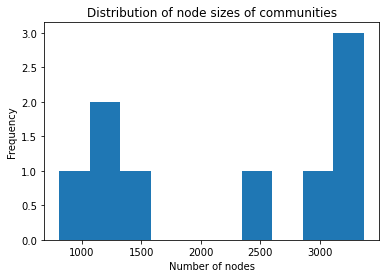

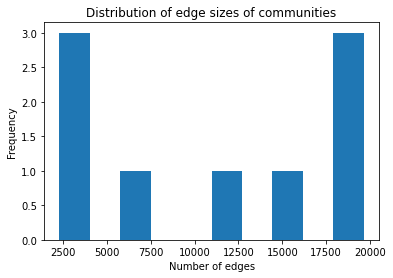

In [ ]:
# get data 
df = spark.createDataFrame(average_community_data_rdd)
df_edge_node = df \
  .withColumn("node_size", F.size("nodes")) \
  .withColumn("edge_size", F.size("edges")) \


# plot distribution of node sizes and edge sizes
df_edge_node_pd = df_edge_node.toPandas()
plt.hist(df_edge_node_pd['node_size'], bins=10)
plt.xlabel('Number of nodes')
plt.ylabel('Frequency')
plt.title('Distribution of node sizes of communities')
plt.show()

plt.hist(df_edge_node_pd['edge_size'], bins=10)
plt.xlabel('Number of edges')
plt.ylabel('Frequency')
plt.title('Distribution of edge sizes of communities')
plt.show()

In [14]:
print(f"number of communities: {average_community_data_rdd.count()}")

# filter pair
number_of_groups_node = 2
number_of_groups_edge = 3

# nodes
t0 = time.time()
#Creating Datafram of grouped communities
grouped_communities_node=rdd_community_to_dataframe_paired_community_by_column(average_community_data_rdd, number_of_groups_node, 'node_size')

#Converting it to RDD
pairs_rdd_filtering_nodes = grouped_communities_node.rdd
t1 = time.time()
total_node = t1-t0
print(f"node time: {total_node}, count of pairs: {pairs_rdd_filtering_nodes.count()}")

#edges
t2 = time.time()
#Creating Datafram of grouped communities
grouped_communities_edge=rdd_community_to_dataframe_paired_community_by_column(average_community_data_rdd, number_of_groups_edge, 'edge_size')

#Converting it to RDD
pairs_rdd_filtering_edge = grouped_communities_edge.rdd
t3 = time.time()
total_edge = t3-t2
print(f"edge time: {total_edge}, count of pairs: {pairs_rdd_filtering_edge.count()}")

number of communities: 9


24/11/09 18:49:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/09 18:49:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/09 18:49:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/09 18:49:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/09 18:49:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/09 18:49:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/09 1

node time: 2.210094928741455, count of pairs: 16


24/11/09 18:49:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/09 18:49:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/09 18:49:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/09 18:49:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/09 18:49:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/09 18:49:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/09 1

edge time: 1.5032532215118408, count of pairs: 9


## Calculate similarity distances

In [ ]:
# all pairs
cartesian_pairs_rdd
unique_pairs_rdd
pairs_rdd_filtering_edge
pairs_rdd_filtering_nodes

def compute_similarity_alt(row):
    # Extract community data from the row
    community1 = {
        'community_id': row['community_id_1'],
        'nodes': row['nodes_1'],
        'edges': row['edges_1']
    }
    community2 = {
        'community_id': row['community_id_2'],
        'nodes': row['nodes_2'],
        'edges': row['edges_2']
    }
    group = row['group']

    # Compute the distance using the Compare function
    distance = Compare(community1, community2)

    # Return a tuple: (group, community_id1, community_id2, distance)
    return (group, community1['community_id'], community2['community_id'], distance)


# pair similarity functions and plot distribution
def pair_simi_plot(pairs_rdd, alt_version=False):
  if alt_version:
    results_rdd = pairs_rdd.map(compute_similarity_alt)
  else:
    #Calculate Distance
    results_rdd = pairs_rdd.map(lambda pair: (pair, Compare(pair[0], pair[1])))
    
  results = results_rdd.collect()

  # Collect the results into a list of tuples (community_id1, community_id2, distance)
  similarities = []

  if alt_version:
    # temp_similarities = defaultdict(list)
    for group, community_id1, community_id2, distance in results:
      similarities.append((community_id1, community_id2, distance))
      
  else:
    for pair, comparison_result in results:
      community_id1 = pair[0]['community_id']
      community_id2 = pair[1]['community_id']
      distance = comparison_result
      similarities.append((community_id1, community_id2, distance))

  return similarities

In [50]:
# calculate distances between pairing methods
t0 = time.time()
similarity_cartesian = pair_simi_plot(cartesian_pairs_rdd)
t1 = time.time()
similarity_unique = pair_simi_plot(unique_pairs_rdd)
t2 = time.time()
similarity_edge = pair_simi_plot(pairs_rdd_filtering_edge, True)
t3 = time.time()
similarity_node = pair_simi_plot(pairs_rdd_filtering_nodes, True)
t4 = time.time()

# print time each similarity calculation took on the pairs
print(f"cartesian time: {t1-t0}")
print(f"unique time: {t2-t1}")
print(f"edge time: {t3-t2}")
print(f"node time: {t4-t3}")

# Extract distances for analysis
distances_cartesian = [distance for _, _, distance in similarity_cartesian]
distances_unique = [distance for _, _, distance in similarity_unique]
distances_edge = [distance for _, _, distance in similarity_edge]
distances_node = [distance for _, _, distance in similarity_node]

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy

cartesian time: 50.34459400177002
unique time: 25.036973237991333
edge time: 23.70632266998291
node time: 40.09674668312073


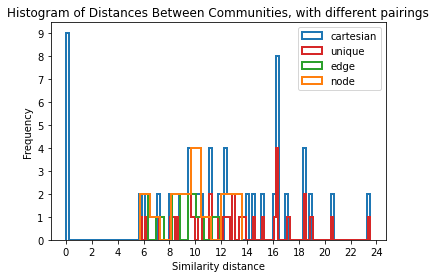

<Figure size 1440x1440 with 0 Axes>

In [62]:
# plot distribution of similarities in same graph
plt.hist(distances_cartesian, bins=100, histtype='step', linewidth=2, label='cartesian', color='#1f77b4')
plt.hist(distances_unique, bins=100, histtype='step', linewidth=2, label='unique', color='#d62728')
plt.hist(distances_edge, bins=10, histtype='step', linewidth=2, label='edge', color='#2ca02c')
plt.hist(distances_node, bins=10, histtype='step', linewidth=2, label='node', color='#ff7f0e')
plt.xlabel('Similarity distance')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 25, step=2))
plt.yticks(np.arange(0, 10, step=1))
plt.title('Histogram of Distances Between Communities, with different pairings')
plt.legend(loc='upper right')
plt.figure(figsize=(20,20))
plt.show()

In [48]:
#Calculate Distance
results_rdd = unique_pairs_rdd.map(lambda pair: (pair, Compare(pair[0], pair[1])))

#Print
results = results_rdd.collect()

# Collect the results into a list of tuples (community_id1, community_id2, distance)
similarities = []

for pair, comparison_result in results:
    community_id1 = pair[0]['community_id']
    community_id2 = pair[1]['community_id']
    distance = comparison_result
    similarities.append((community_id1, community_id2, distance))

# Optionally, print the collected similarities
# print("Collected Similarities:")
# for sim in similarities:
#     print(f"Community {sim[0]} and Community {sim[1]}: Distance = {sim[2]}")

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy

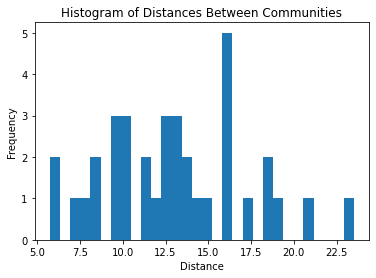

In [ ]:
# Extract distances for analysis
distances = [distance for _, _, distance in similarities]

# Plot histogram of distances
plt.hist(distances, bins=30)
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Distances Between Communities')
plt.show()

In [36]:
# Calculate mean and standard deviation
mean_distance = np.mean(distances)
std_distance = np.std(distances)

# Set threshold at one standard deviation below the mean
threshold = mean_distance - std_distance
print(threshold)

5.692749262868561


In [ ]:
#From the histogram we can see a gap around distance of 5. 
threshold = 5.0

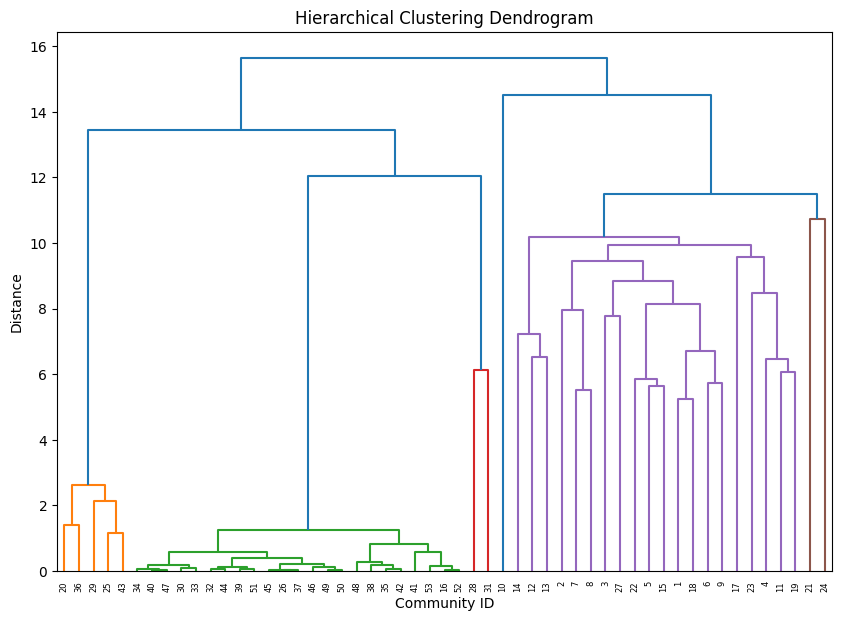


Groups of Similar Communities (Hierarchical Clustering):
Group 7: [1, 5, 6, 9, 15, 18, 22]
Group 5: [2, 7, 8]
Group 6: [3, 27]
Group 8: [4, 11, 19, 23]
Group 12: [10]
Group 4: [12, 13, 14]
Group 2: [16, 26, 30, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
Group 9: [17]
Group 1: [20, 25, 29, 36, 43]
Group 10: [21]
Group 11: [24]
Group 3: [28, 31]


24/11/06 19:46:45 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1897498 ms exceeds timeout 120000 ms
24/11/06 19:46:45 WARN SparkContext: Killing executors is not supported by current scheduler.
24/11/06 19:46:46 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$

In [ ]:


# Assume 'similarities' is your list of (community_id1, community_id2, distance)
community_ids = sorted(set([id for sim in similarities for id in sim[:2]]))
id_to_index = {id: idx for idx, id in enumerate(community_ids)}
N = len(community_ids)

# Initialize a full distance matrix with zeros
distance_matrix = np.zeros((N, N))

# Fill in the distances
for community_id1, community_id2, distance in similarities:
    i, j = id_to_index[community_id1], id_to_index[community_id2]
    distance_matrix[i, j] = distance
    distance_matrix[j, i] = distance  # Symmetric matrix

# Convert to condensed distance matrix required for linkage
condensed_dists = squareform(distance_matrix)

# Perform hierarchical clustering
Z = linkage(condensed_dists, method='average')

# Plot the dendrogram (optional)


plt.figure(figsize=(10, 7))
dendrogram(Z, labels=community_ids)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Community ID')
plt.ylabel('Distance')
plt.show()

# Choose a threshold based on the dendrogram
threshold = 8.5  # Adjust as necessary

# Get cluster labels
cluster_labels = fcluster(Z, t=threshold, criterion='distance')

# Group communities by cluster labels
groups = defaultdict(list)
for community_id, cluster_label in zip(community_ids, cluster_labels):
    groups[cluster_label].append(community_id)

# Output the groups
print("\nGroups of Similar Communities (Hierarchical Clustering):")
for cluster_label, community_list in groups.items():
    print(f"Group {cluster_label}: {sorted(community_list)}")


[[ 0.          9.34676479  8.62705576 ... 14.38404999 15.49827785
  15.58070304]
 [ 9.34676479  0.         10.57166301 ... 14.57154454 15.59822246
  15.67906802]
 [ 8.62705576 10.57166301  0.         ... 14.25023671 15.35715553
  15.43080407]
 ...
 [14.38404999 14.57154454 14.25023671 ...  0.          1.19071875
   1.28324224]
 [15.49827785 15.59822246 15.35715553 ...  1.19071875  0.
   0.16436168]
 [15.58070304 15.67906802 15.43080407 ...  1.28324224  0.16436168
   0.        ]]


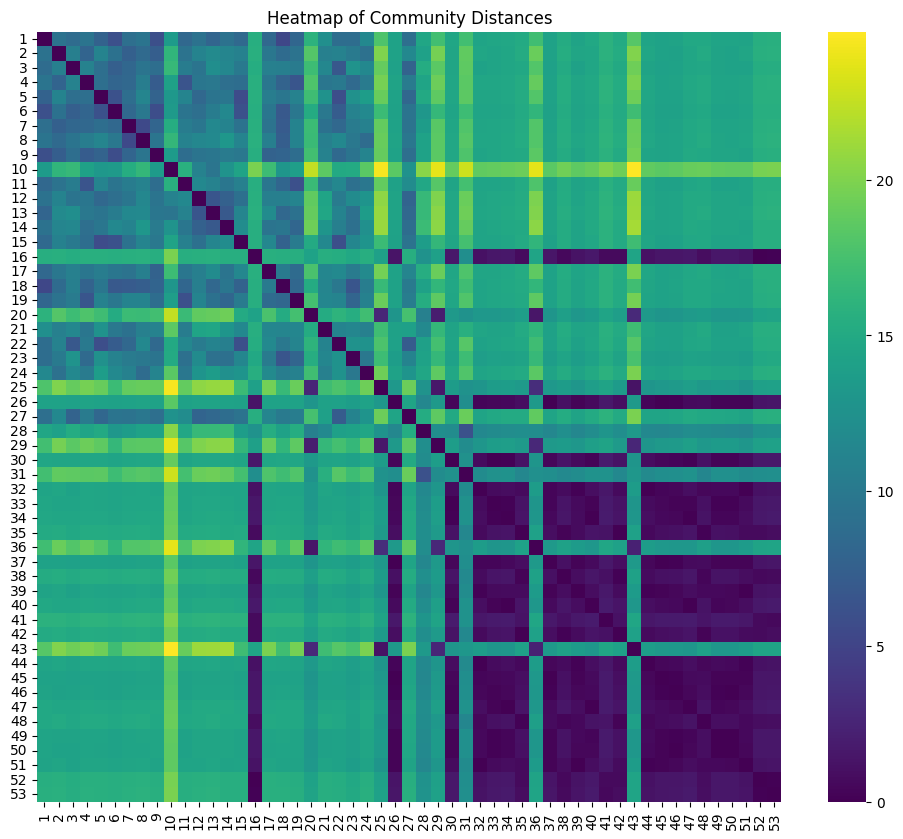

In [ ]:
print(distance_matrix)


plt.figure(figsize=(12, 10))
sns.heatmap(distance_matrix, xticklabels=community_ids, yticklabels=community_ids, cmap='viridis')
plt.title('Heatmap of Community Distances')
plt.show()

In [52]:
min_distance = np.min(distances)
max_distance = np.max(distances)
mean_distance = np.mean(distances)
median_distance = np.median(distances)
print(f"Min Distance: {min_distance}")
print(f"Max Distance: {max_distance}")
print(f"Mean Distance: {mean_distance}")
print(f"Median Distance: {median_distance}")


Min Distance: 0.016849063604070257
Max Distance: 24.77347356300174
Mean Distance: 11.492310520010651
Median Distance: 14.160732847911753


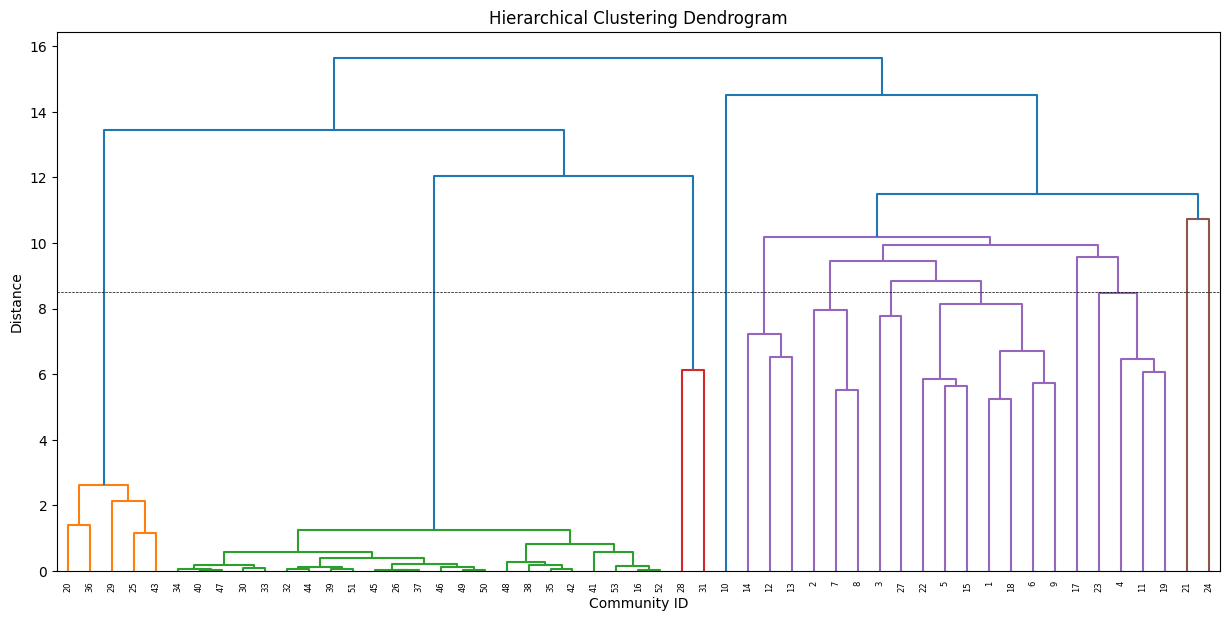

In [ ]:
plt.figure(figsize=(15, 7))
dendrogram(Z, labels=community_ids, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Community ID')
plt.ylabel('Distance')
plt.axhline(y=threshold, c='k', ls='--', lw=0.5)
plt.show()


In [54]:
linkage_methods = ['single', 'complete', 'average', 'ward']
for method in linkage_methods:
    Z = linkage(condensed_dists, method=method)
    cluster_labels = fcluster(Z, t=threshold, criterion='distance')

    # Group communities
    groups = defaultdict(list)
    for community_id, cluster_label in zip(community_ids, cluster_labels):
        groups[cluster_label].append(community_id)

    # Output the groups for each method
    print(f"\nLinkage Method: {method}")
    for cluster_label, community_list in groups.items():
        print(f"Group {cluster_label}: {sorted(community_list)}")



Linkage Method: single
Group 1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 17, 18, 19, 22, 23, 27]
Group 4: [10]
Group 5: [16, 26, 30, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
Group 6: [20, 25, 29, 36, 43]
Group 3: [21]
Group 2: [24]
Group 7: [28, 31]

Linkage Method: complete
Group 9: [1, 6, 9, 18]
Group 10: [2, 7, 8]
Group 6: [3, 27]
Group 11: [4, 11, 19]
Group 5: [5, 15, 22]
Group 14: [10]
Group 4: [12, 13, 14]
Group 2: [16, 26, 30, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
Group 13: [17]
Group 1: [20, 25, 29, 36, 43]
Group 7: [21]
Group 12: [23]
Group 8: [24]
Group 3: [28, 31]

Linkage Method: average
Group 7: [1, 5, 6, 9, 15, 18, 22]
Group 5: [2, 7, 8]
Group 6: [3, 27]
Group 8: [4, 11, 19, 23]
Group 12: [10]
Group 4: [12, 13, 14]
Group 2: [16, 26, 30, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
Group 9: [17]
Group 1: [20, 25, 29, 36, 43]
Group 10: [21]
Group 11: [